In [18]:
import numpy as np
import NegotiationTools as negtools
import matplotlib.pyplot as plt
from NegotiationConfig import *
from skimage.draw import rectangle
import pandas as pd
import seaborn as sb
import datetime
import math

stats = negtools.StatisticsLogger()
nt = negtools.NegTools()
import Negotiation as neg
import Experiments as exp

## Templates
A template is the basic form of the ground truth and predictions. It is then converted into a prediction by replicating it for each label/agent. Different objects are labeled with integer numbers, with 0 being the background.

In [39]:
W = 25
H = 25
W2 = 5
H2 = 5
templates = dict()

templates['pixel_spot'] = np.zeros((W, H), dtype=np.uint8)
templates['pixel_spot'][2,2] = 1

templates['single_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['single_sq'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['multi_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['multi_sq'][1,1] = 1
templates['multi_sq'][1,3] = 2
templates['multi_sq'][3,1] = 3
templates['multi_sq'][3,3] = 4

templates['bin_blob'] = np.zeros((W, H), dtype=np.uint8)
templates['bin_blob'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['bin_chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,W2):
    for j in range(0,H,H2):
        if is_one is True:
            templates['bin_chk'][tuple(rectangle(start=(i,j), extent=(W2,H2), shape=(W,H)))] = 1
        is_one = not is_one
        
n_class = 4
blobs_w = 8
blobs_h = 8
w_off = 2
h_off = 2
blobs_val = 1

templates['blobs'] = np.zeros((W, H), dtype=np.uint8)
for i in range(0,W,blobs_w+2*w_off):
    for j in range(0,H,blobs_h+2*h_off):
        templates['blobs'][tuple(rectangle(start=(i+w_off,j+h_off), extent=(blobs_w,blobs_h), shape=(W,H)))] = blobs_val
        blobs_val = blobs_val+1

W = 25
H = 25
CHK_W = 5
CHK_H = 5
val = 0
n_class = 4
templates['chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,CHK_W):
    for j in range(0,H,CHK_H):
        templates['chk'][tuple(rectangle(start=(i,j), extent=(CHK_W,CHK_H), shape=(W,H)))] = val + 1
        val = (val + 1) % n_class




def template_overlapped(size, overlap):
    template = np.zeros((size, size), dtype=np.uint8)
    half = int(size/2)
    quarter = int(half/2)
    offset = int(overlap*(size-2)/4)
    
    template[quarter+1:size-quarter-1, 1+offset:half+offset] = 1
    template[quarter+1:size-quarter-1, half-offset:size-1-offset] = 2
    template[quarter+1:size-quarter-1, half-offset:half+offset] = 3
    # Draw the squares in an inverse fashion
    plt.imshow(template)


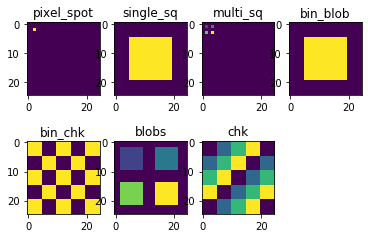

In [40]:
for i, (name, templ) in enumerate(templates.items()):
    plt.subplot(2, math.ceil(len(templates.items())/2), i+1)
    plt.imshow(templ)
    plt.title(name)

In [42]:
print(templates['blobs'])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 

## Synthetic Samples
Synthetic samples are generated by simulating the softmax output of the agents across the labels upon a given te

In [4]:
def generate_samples(template, objects_gt, confidences):
    '''
    Simulates the agent output given an input confidence vector and a ground truth.
    template: the sample template to be used
    objects_gt: List of ordinal labels corresponding to each object in the template (including the background).
    agent predictions: nested list structures. The shape must be (agents, objects, labels) where object is the number of different segmentation areas in the template (EXCLUDING the background). 
    '''
    n_labels = len(CHANNEL_NAMES)
    n_agents = len(AGENT_NAMES)
    
    # Input checking
    
    assert np.all(np.around(np.array(confidences).sum(axis=-1), decimals=4)==1.0), "Confidences does not sum to 1.0"
    
    # Ground truth generation
    
    gt = list()
    for current_label in range(n_labels):
        gt_slice = np.zeros_like(template)
        # Iterate on template objects
        for obj_template_value in np.unique(template):
            # Paint the object if the object_gt indicates the current label for this object
            if objects_gt[obj_template_value] == current_label:
                gt_slice = np.where(template == obj_template_value, 1.0, gt_slice)
        gt.append(gt_slice)
    gt = np.stack(gt, axis=-1)
    
    # Proposals generation
    proposals = list()
    for agent in range(n_agents):
        # plt.figure(figsize=(12,6))
        
        ag_proposal = list()
        for current_label in range(n_labels):
            pr_slice = np.zeros_like(template, dtype=np.float32)
            # Iterate on template objects
            for obj_template_value in np.unique(template):
                if obj_template_value == 0:
                    if current_label == 0:
                        value = 1.
                    else:
                        value = 0.
                    pr_slice = np.where(template == obj_template_value, value, pr_slice)
                    continue
                    
                # Paint the object if the object_gt indicates the current label for this object
                value = confidences[agent][obj_template_value-1][current_label]
                pr_slice = np.where(template == obj_template_value, value, pr_slice)
            
#             plt.subplot(1, n_labels, current_label+1)
#             plt.imshow(pr_slice, cmap='Greys_r', vmin=0.0, vmax=1.0)
            ag_proposal.append(pr_slice)
        
        ag_proposal = np.stack(ag_proposal, axis=-1)
        proposals.append(ag_proposal)
    proposals = np.stack(proposals)
    
    return gt, proposals

def run_experiment(experiment, a, b, noise_samples=0, noise_std=0.25, MAX_STEPS=1000):
    ''' 
    Runs a given experiment with the given parameters and returns a DataFrame with the corresponding statistics
    
    :param experiment - Function to run with the a, b parameters that returns a vector of ground truths and proposals
    :param a, b - parameters for the experiment
    :param noise_std - Standard Deviation for the noise to add to the proposals.
    :param noise_samples - How many runs to perform with the noise. If it's zero, a single run is performed and no noise is applied
    :param MAX_STEPS - Negotiation steps timeout
    '''
    gt, prop = experiment(a, b)

    mask = np.logical_not(nt.get_consensus(prop))
    if np.all(~mask):
        # Consensus may be enforced by construction, in these case we consider all the image
        mask = None

    results = pd.DataFrame()
    
    # One shot methods
    mv_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='majority voting', noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    mv_results['method'] = 'Majority Voting'
    results = results.append(mv_results, ignore_index=True, sort=False)

    mean_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='mean', noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    mean_results['method'] = 'Mean Proposal'
    results = results.append(mean_results, ignore_index=True, sort=False)

    max_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='maximum', noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    max_results['method'] = 'Maximum Proposal'
    results = results.append(max_results, ignore_index=True, sort=False)
     
    # Weighted Average methods based on confidence
    confidence_functions = [lambda x: nt.get_confidence(x, method='pixelwise_entropy')]*len(AGENT_NAMES)
    wa_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='weighted_mean_confidence', confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    wa_results['method'] = 'Weighted Mean - Pixelwise Entropy'
    results = results.append(wa_results, ignore_index=True, sort=False)
    
    confidence_functions = [lambda x: nt.get_confidence(x, method='mean_entropy')]*len(AGENT_NAMES)
    wa_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='weighted_mean_confidence', confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    wa_results['method'] = 'Weighted Mean - Mean Entropy'
    results = results.append(wa_results, ignore_index=True, sort=False)
    
    confidence_functions = [lambda x: nt.get_confidence(x, method='convolution_entropy', convolution_size=3)]*len(AGENT_NAMES)
    wa_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='weighted_mean_confidence', confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    wa_results['method'] = 'Weighted Mean - 3x3 Conv Entropy'
    results = results.append(wa_results, ignore_index=True, sort=False)
    
    confidence_functions = [lambda x: nt.get_confidence(x, method='convolution_entropy', convolution_size=5)]*len(AGENT_NAMES)
    wa_results = exp.run_simple_aggregation(prop, gt, mask, agg_method='weighted_mean_confidence', confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, binary_strategy='maximum')
    wa_results['method'] = 'Weighted Mean - 5x5 Conv Entropy'
    results = results.append(wa_results, ignore_index=True, sort=False)
    
    # Negotiation based methods (Only keeps the last agreement)
    # Pixelwise entropy
    confidence_functions = [lambda x: nt.get_confidence(x, method='pixelwise_entropy')]*len(AGENT_NAMES)
    neg_results = exp.run_negotiation(prop, gt, mask, confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, MAX_STEPS=MAX_STEPS)
    neg_results['method'] = 'Negotiation - Pixelwise Entropy'
    results = results.append(neg_results, ignore_index=True, sort=False)
    
    # Mean entropy
    confidence_functions = [lambda x: nt.get_confidence(x, method='mean_entropy')]*len(AGENT_NAMES)
    neg_results = exp.run_negotiation(prop, gt, mask, confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, MAX_STEPS=MAX_STEPS)
    neg_results['method'] = 'Negotiation - Mean Entropy'
    results = results.append(neg_results, ignore_index=True, sort=False)
    
    # Convolution entropy 3x3
    confidence_functions = [lambda x: nt.get_confidence(x, method='convolution_entropy', convolution_size=3)]*len(AGENT_NAMES)
    neg_results = exp.run_negotiation(prop, gt, mask, confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, MAX_STEPS=MAX_STEPS)
    neg_results['method'] = 'Negotiation - 3x3 Conv Entropy'
    results = results.append(neg_results, ignore_index=True, sort=False)
    
    # Convolution entropy 5x5
    confidence_functions = [lambda x: nt.get_confidence(x, method='convolution_entropy', convolution_size=5)]*len(AGENT_NAMES)
    neg_results = exp.run_negotiation(prop, gt, mask, confidence_functions=confidence_functions, noise_samples=noise_samples, noise_std=noise_std, MAX_STEPS=MAX_STEPS)
    neg_results['method'] = 'Negotiation - 5x5 Conv Entropy'
    results = results.append(neg_results, ignore_index=True, sort=False)
    
    results['a'] = np.around(a, decimals=4)
    results['b'] = np.around(b, decimals=4)
    
    return results

def robustness(experiment, amin=0, amax=1, bmin=0, bmax=1, steps=10, noise_samples=0, noise_std=0.25):
    ''' Perform the given experiment by varying the a and b parameters within the given range for the given number of steps. Returns a DataFrame with the statistics'''
    log = pd.DataFrame()
    for a in np.linspace(amin, amax, num=steps, endpoint=True):
        for b in np.linspace(bmin, bmax, num=steps, endpoint=True):
            log = log.append(run_experiment(experiment, a, b, noise_samples=noise_samples, noise_std=noise_std), ignore_index=True, sort=False)
    return log


def show_heatmap(data, metric, max_cols=3):
    ''' Show the heatmap for one experiment. 
        data: must be a DataFrame having an integer index and at least the columns 'a', 'b', 'method' and the remaining columns are statistics that could be shown.
        metric: name of the column to display in the heatmap
    '''
    sb.set()
    sb.set_style('whitegrid')
    all_methods = data['method'].unique()
    max_rows = (len(all_methods)//max_cols) + (0 if len(all_methods)%max_cols==0 else 1)
    plt.figure(figsize=(10*max_rows,10*max_cols))
    for m, method in enumerate(all_methods):
        pivoted = data[data['method']==method][['a', 'b', metric]].pivot('a', 'b')[metric]
        plt.subplot(max_rows, max_cols, m+1)
        ax = sb.heatmap(pivoted, vmin=0.0, vmax=1.0)
        ax.invert_yaxis()
        plt.title(method + " ({})".format(metric))
    plt.show()

### 1a
Template: single box.

Agent A has confidence "a" in label 1 and the remaining (1-a) is equally spread between the other labels 

Agents B, C, D has confidence "b" in label 1 and confidence (1-b)/5 in labels 0, 1, 3, 4, with b < a

In [5]:
# Experiment 1

def exp_1_confidences(a, b):
    '''
    Generate a confidence matrix for the experiment 1
    a: Confidence of agent 1 in label 1
    b: Confidence of agents 2, 3, 4 in label 2
    '''
    nota = (1-a)/(len(CHANNEL_NAMES)-1)
    notb = (1-b)/(len(CHANNEL_NAMES)-1)
    confidences = list()
    for ag in range(len(AGENT_NAMES)):
        if ag == 0:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(a if lab==1 else nota)
            confidences.append([labs])
        else:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(b if lab==2 else notb)
            confidences.append([labs])        
    return confidences

exp_1 = lambda a, b: generate_samples(templates['single_sq'], objects_gt=[0, 1], confidences=exp_1_confidences(a, b))

In [7]:
noise_samples = 30 # How many runs to run for each (a, b) + noise
noise_std = 0.125 # noise STD
data = robustness(exp_1, amin=1/5, bmin=1/5, steps=10, noise_samples=noise_samples, noise_std=noise_std)
data.to_csv('results/{}_exp1_std_{}_samples_{}.csv'.format(str(datetime.datetime.now()), noise_std, noise_samples))

Sample 0 Consensus Reached at step, current step: 5
Sample 1 Consensus Reached at step, current step: 5
Sample 2 Consensus Reached at step, current step: 5
Sample 3 Consensus Reached at step, current step: 9
Sample 4 Consensus Reached at step, current step: 5
Sample 5 Consensus Reached at step, current step: 5
Sample 6 Consensus Reached at step, current step: 5
Sample 7 Consensus Reached at step, current step: 5
Sample 8 Consensus Reached at step, current step: 4
Sample 9 Consensus Reached at step, current step: 4
Sample 10 Consensus Reached at step, current step: 5
Sample 11 Consensus Reached at step, current step: 6
Sample 12 Consensus Reached at step, current step: 4
Sample 13 Consensus Reached at step, current step: 4
Sample 14 Consensus Reached at step, current step: 6
Sample 15 Consensus Reached at step, current step: 4
Sample 16 Consensus Reached at step, current step: 5
Sample 17 Consensus Reached at step, current step: 6
Sample 18 Consensus Reached at step, current step: 5
Sam

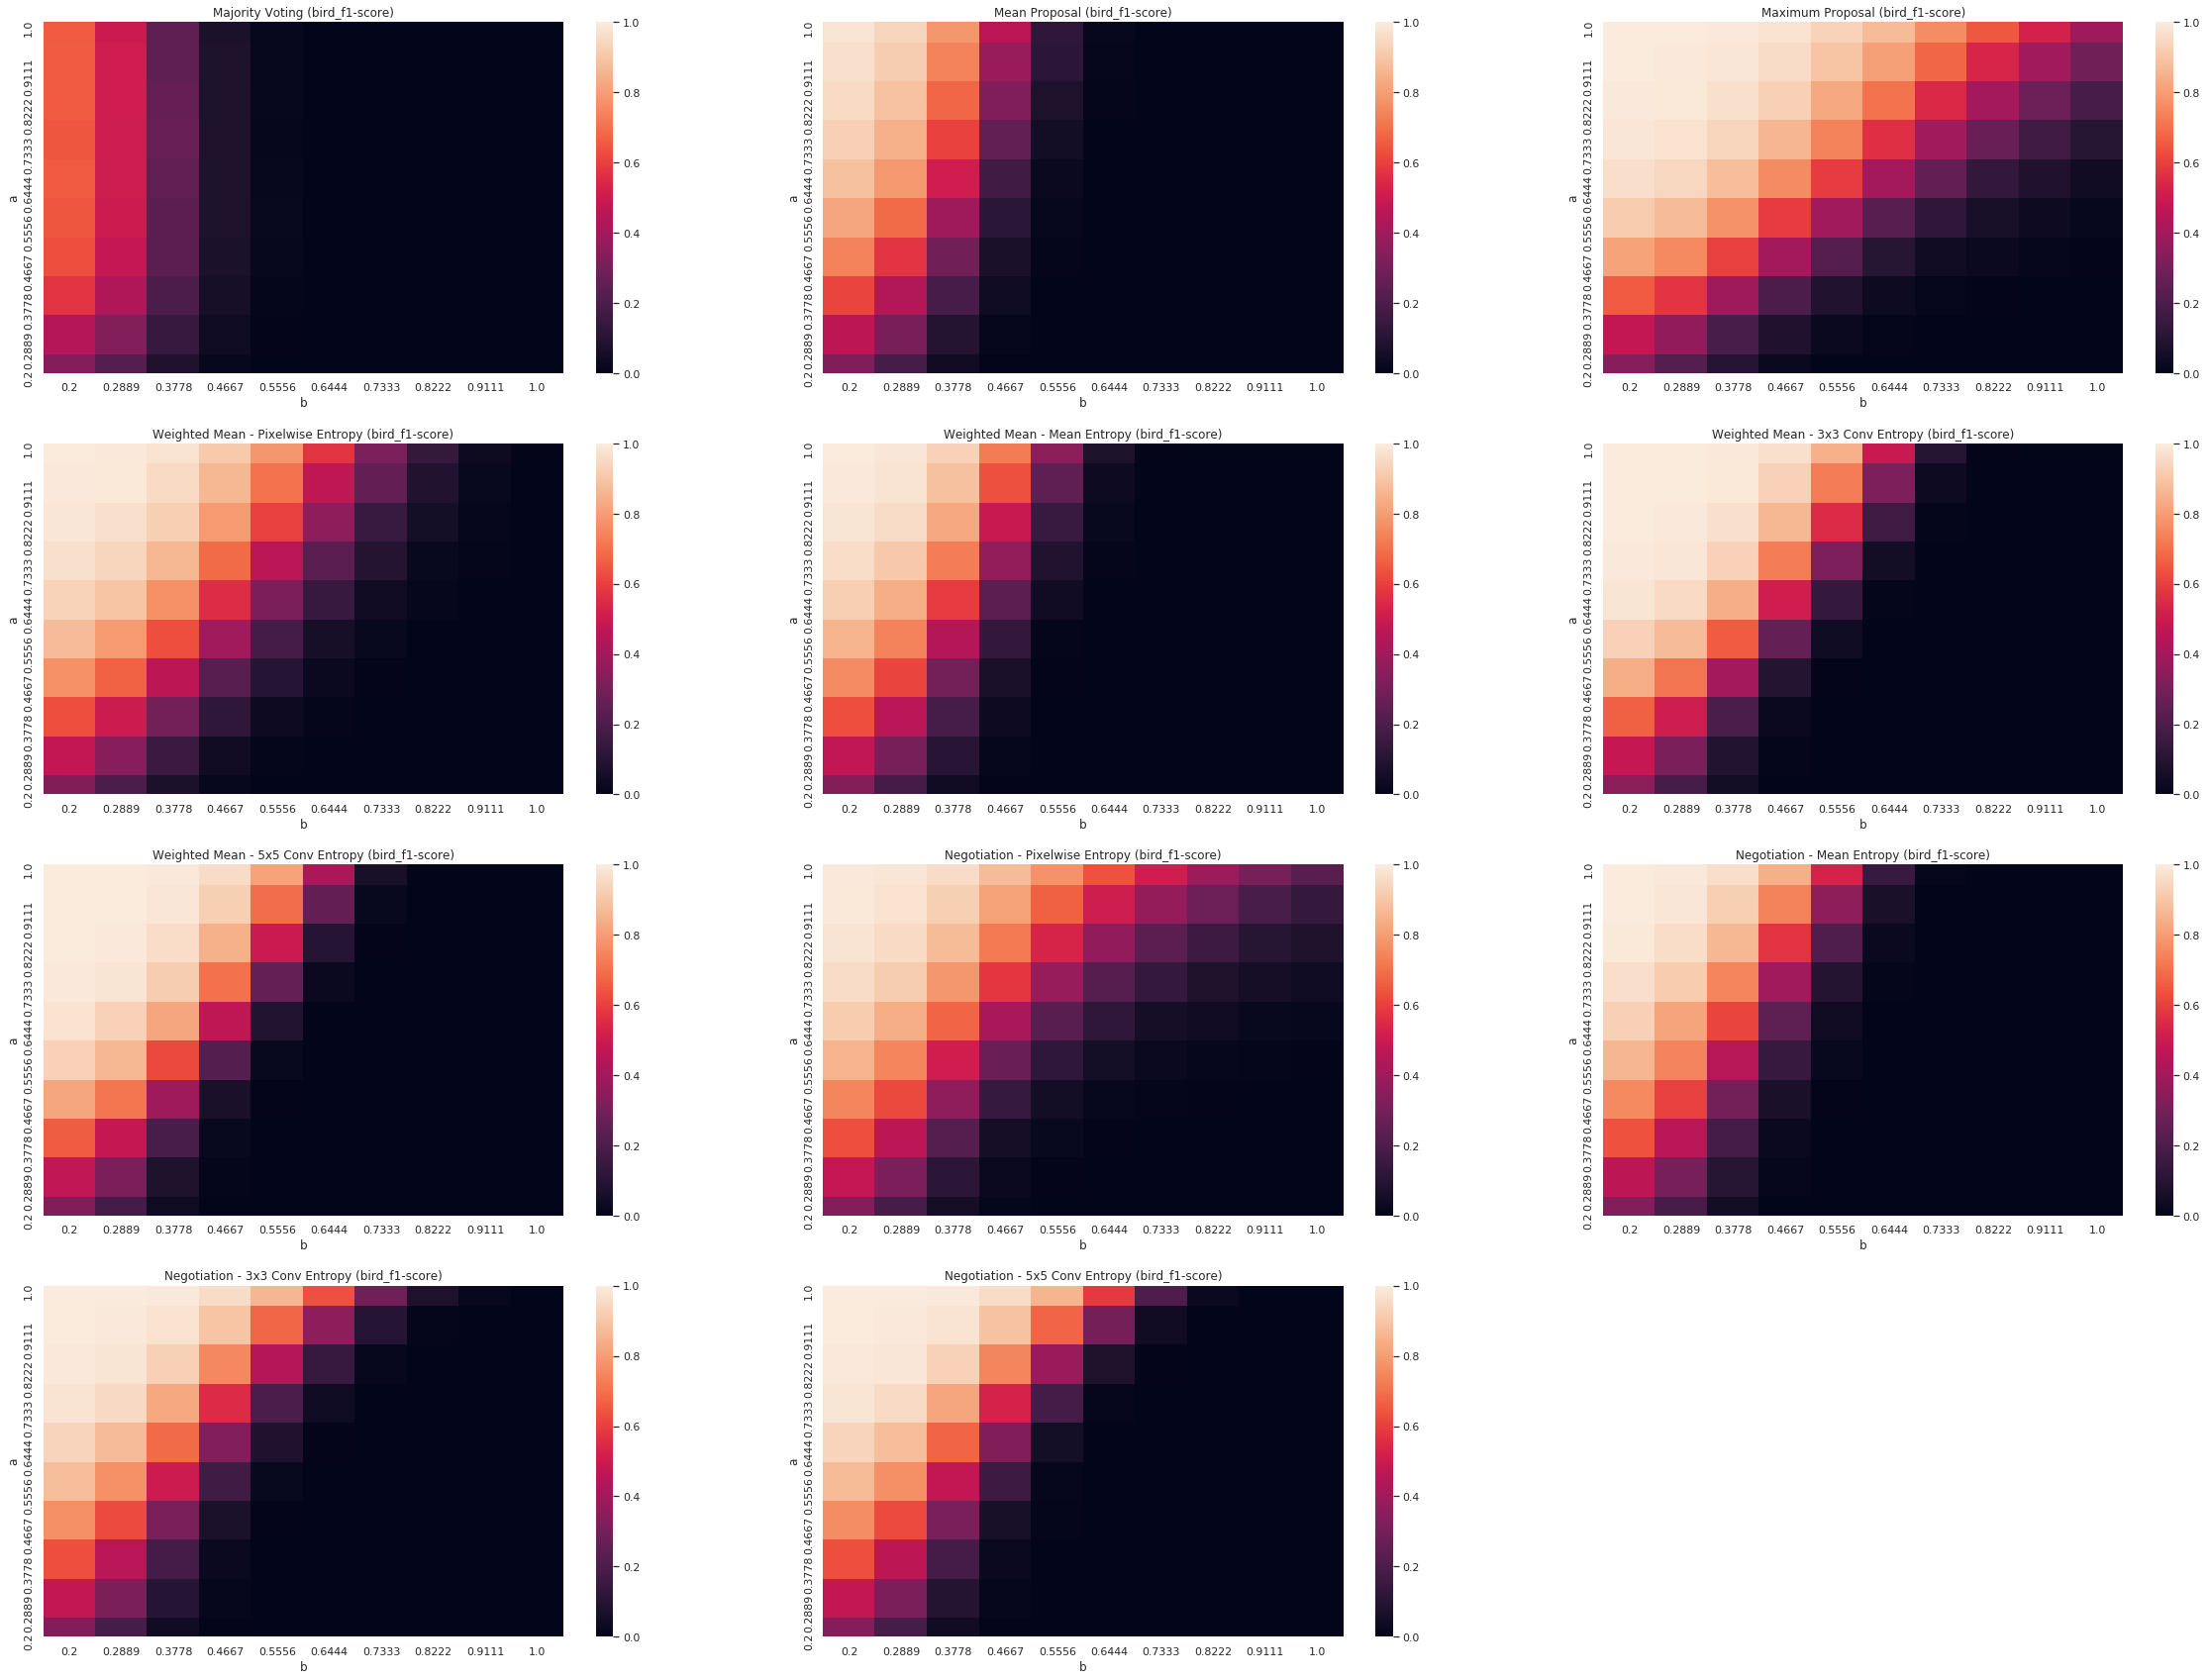

ValueError: fname must be a PathLike or file handle

<Figure size 432x288 with 0 Axes>

In [10]:
show_heatmap(data, 'bird_f1-score')

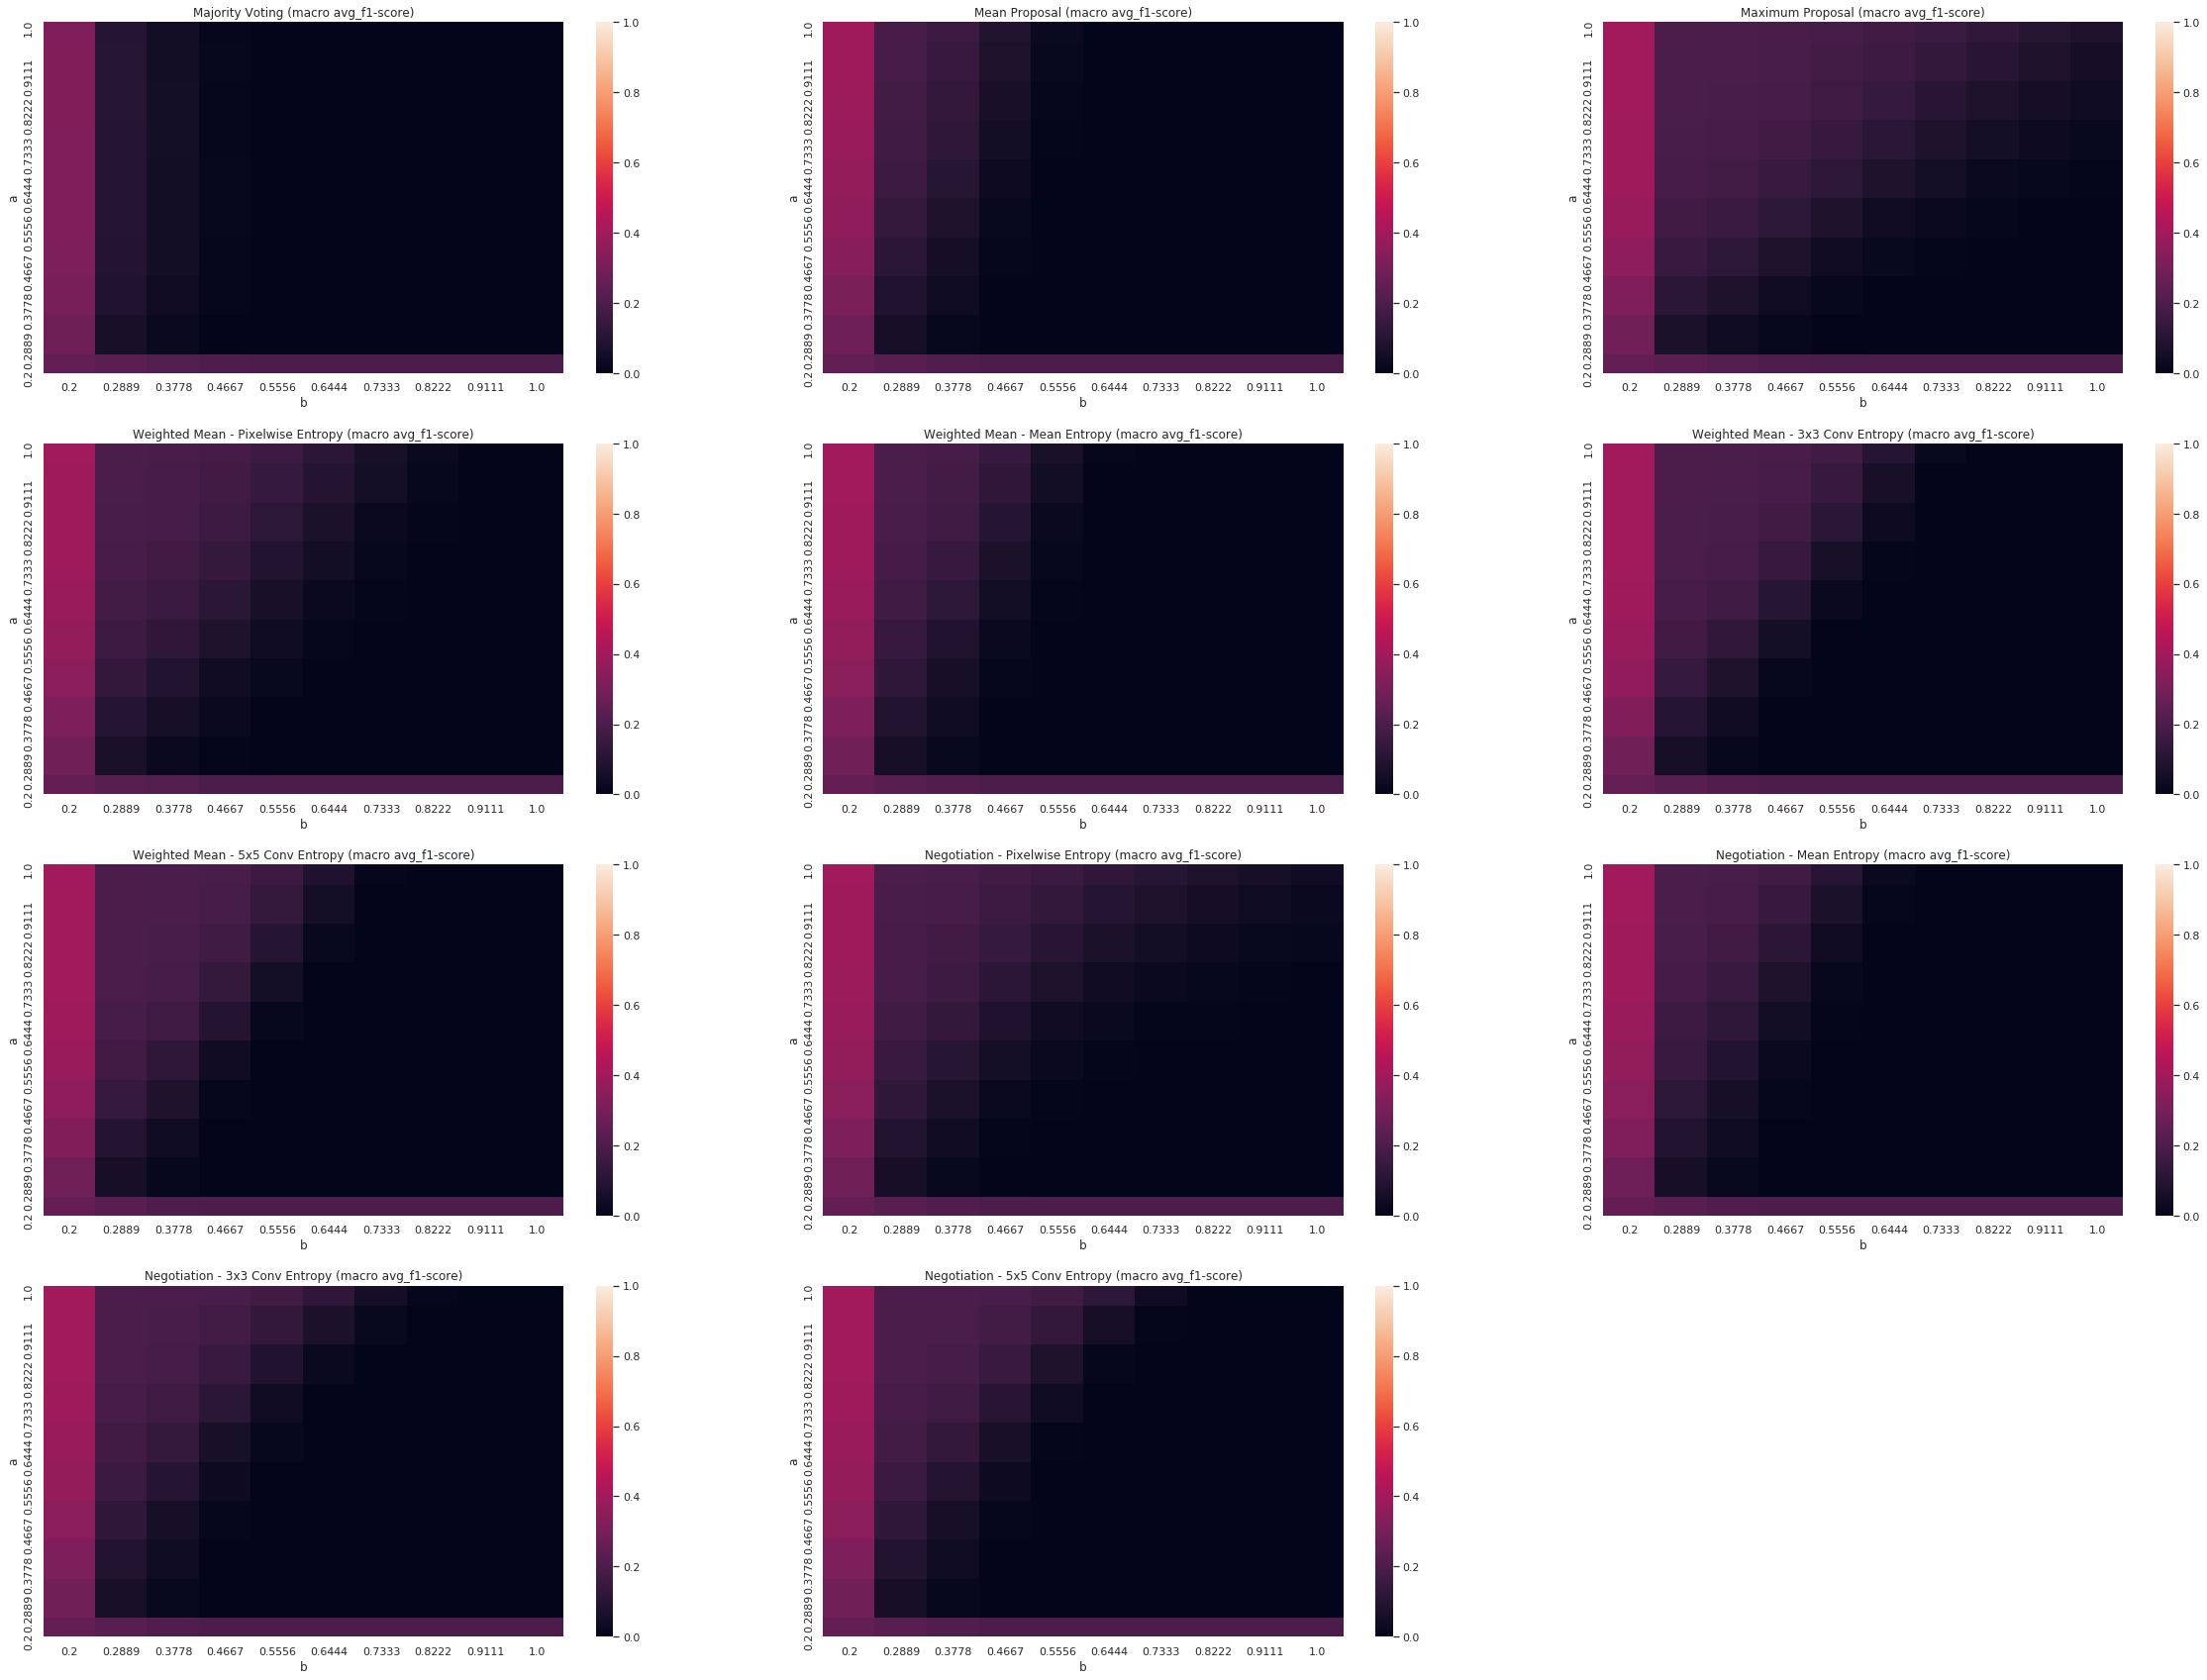

In [9]:
show_heatmap(data, 'macro avg_f1-score')

### 2
Template: multi squares.
The ground truth is composed of a different prediction for each object in the template. That is, each object i has label Li.
The agents are symmetrical. Each agent Ai has confidence alpha for the object i and confidence beta for the remaining objects/labels.

In [ ]:
def exp_2_confidences(a, b, template):
    '''
    Generate a confidence matrix for the experiment 2
    a: Confidence of the agents in the label they are most proficient
    b: Confidence of the agents in the other labels
    '''
    nota = (1-a)/(len(CHANNEL_NAMES)-1)
    notb = (1-b)/(len(CHANNEL_NAMES)-1)
    
    agents = list()
    for ag in range(len(AGENT_NAMES)):
        objs = list()
        for obj in np.unique(template):
            if obj==0:
                continue # Skipping the background (managed by generate_samples)
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                #labs.append((ag, obj, lab))
                if ag == obj -1:
                    if lab == obj:
                        labs.append(a)
                    else:
                        labs.append(nota)
                else:
                    if lab == obj:
                        labs.append(b)
                    else:
                        labs.append(notb)
            objs.append(labs)
        agents.append(objs)
    return agents

template = templates['multi_sq']
exp_2 = lambda a, b: generate_samples(template, objects_gt=[0, 1, 2, 3, 4], confidences=exp_2_confidences(a, b, template))

#negtools.plot(proposals=prop, ground_truth=gt)
data = robustness(exp_2, amin=1/5, bmin=1/5)

In [ ]:
show_heatmap(data, 'weighted avg_f1-score')

In [ ]:
show_heatmap(data, 'macro avg_f1-score')

In [ ]:
show_heatmap(data, 'accuracy')